# SCA using hamming weight for classification.

Example from [here]() TODO

In [65]:
import random

import h5py
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *

from src.tools.plotter import init_plots
from src.trace_set.database import Database
from src.trace_set.pollution import PollutionType, Pollution
from src.trace_set.set_hw import TraceSetHW

init_plots()

In [66]:
AES_Sbox = np.array([
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
])


# labelize for key guesess for guessing entropy and success rate
def aes_labelize_ge_sr(plt_attack, byte, key, leakage):
    pt_ct = [row[byte] for row in plt_attack]

    key_byte = np.full(len(pt_ct), key[byte])
    state = [int(x) ^ int(k) for x, k in zip(np.asarray(pt_ct[:]), key_byte)]

    intermediate_values = AES_Sbox[state]

    if leakage == "HW":
        return [bin(iv).count("1") for iv in intermediate_values]
    else:
        return intermediate_values

def create_z_score_norm(dataset):
    z_score_mean = np.mean(dataset, axis=0)
    z_score_std = np.std(dataset, axis=0)
    return z_score_mean, z_score_std


def apply_z_score_norm(dataset, z_score_mean, z_score_std):
    for index in range(len(dataset)):
        dataset[index] = (dataset[index] - z_score_mean) / z_score_std


# guessing entropy and success rate
def compute_ge(runs, model, key, correct_key, leakage_model, byte, x_attack, plt_attack, key_rank_report_interval, key_rank_attack_traces):
    nt = len(x_attack)
    nt_interval = int(key_rank_attack_traces / key_rank_report_interval)
    key_ranking_sum = np.zeros(nt_interval)

    # ---------------------------------------------------------------------------------------------------------#
    # compute labels for key hypothesis
    # ---------------------------------------------------------------------------------------------------------#
    labels_key_hypothesis = np.zeros((256, nt))
    for key_byte_hypothesis in range(0, 256):
        key_h = bytearray.fromhex(key)
        key_h[byte] = key_byte_hypothesis
        labels_key_hypothesis[key_byte_hypothesis][:] = aes_labelize_ge_sr(plt_attack, byte, key_h, leakage_model)

    # ---------------------------------------------------------------------------------------------------------#
    # predict output probabilities for shuffled test or validation set
    # ---------------------------------------------------------------------------------------------------------#
    output_probabilities = model.predict(x_attack)

    probabilities_kg_all_traces = np.zeros((nt, 256))
    for index in range(nt):
        probabilities_kg_all_traces[index] = output_probabilities[index][
            np.asarray([int(leakage[index]) for leakage in labels_key_hypothesis[:]])
        ]

    # ---------------------------------------------------------------------------------------------------------#
    # run key rank "runs" times and average results.
    # ---------------------------------------------------------------------------------------------------------#
    for run in range(runs):

        probabilities_kg_all_traces_shuffled = shuffle(probabilities_kg_all_traces,
                                                       random_state=random.randint(0, 100000))

        key_probabilities = np.zeros(256)

        kr_count = 0
        for index in range(key_rank_attack_traces):

            key_probabilities += np.log(probabilities_kg_all_traces_shuffled[index] + 1e-36)
            key_probabilities_sorted = np.argsort(key_probabilities)[::-1]

            if (index + 1) % key_rank_report_interval == 0:
                key_ranking_good_key = list(key_probabilities_sorted).index(correct_key) + 1
                key_ranking_sum[kr_count] += key_ranking_good_key
                kr_count += 1

        print("KR run: {} | final GE for correct key ({}): {})".format(run, correct_key, key_ranking_sum[nt_interval - 1] / (run + 1)))

    guessing_entropy = key_ranking_sum / runs

    return guessing_entropy


def mlp(classes, number_of_samples):
    model = Sequential()
    model.add(Dense(100, activation='relu', input_shape=(number_of_samples,)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(classes, activation='softmax'))
    model.summary()
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [67]:
l_model = "HW"
classes = 9
target_byte = 2
n_profiling = 200000
n_attack = 100000
ns = 1400
correct_key = 34
key = "00112233445566778899AABBCCDDEEFF"

ASCAD_data_folder = "/data/ASCAD/ATMEGA_AES_v1/ATM_AES_v1_variable_key/ASCAD_data/ASCAD_databases/"

with h5py.File(ASCAD_data_folder + "ASCAD_variable.h5", "r") as in_file:
    attack_data = np.zeros((n_attack, 32))
    attack_plaintext = in_file['Attack_traces/metadata']['plaintext']
    attack_key = in_file['Attack_traces/metadata']['key']

    for i in range(n_attack):
        attack_data[i][0:16] = attack_plaintext[i]
        attack_data[i][16:32] = attack_key[i]

# Load the profiling traces
TRACE_SET = TraceSetHW(Database.ascad, Pollution(PollutionType.gauss, 7))
(X_profiling, LABELS_PROF), (X_ATT_ALL, LABELS_ATT_ALL) = TRACE_SET.profile(), TRACE_SET.attack()

X_attack, LABELS_ATT = X_ATT_ALL[:n_attack], LABELS_ATT_ALL[:n_attack]

# normalize with z-score
z_score_mean, z_score_std = create_z_score_norm(X_profiling)
apply_z_score_norm(X_profiling, z_score_mean, z_score_std)
apply_z_score_norm(X_attack, z_score_mean, z_score_std)

X_profiling = X_profiling.astype('float32')
X_attack = X_attack.astype('float32')

# convert labels to categorical labels
Y_profiling = to_categorical(LABELS_PROF, num_classes=classes)
Y_attack = to_categorical(LABELS_ATT, num_classes=classes)

key_rank_report_interval = 1
key_rank_number_of_traces = 100000
key_rank_runs = 1

# train MLP
model = mlp(classes, ns)

# reshape if needed
input_layer_shape = model.get_layer(index=0).input_shape
if len(input_layer_shape) == 3:
    X_profiling = X_profiling.reshape((X_profiling.shape[0], X_profiling.shape[1], 1))
    X_attack = X_attack.reshape((X_attack.shape[0], X_attack.shape[1], 1))
else:
    X_profiling = X_profiling
    X_attack = X_attack

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 100)               140100    
_________________________________________________________________
dense_61 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_62 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_63 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_64 (Dense)             (None, 9)                 909       
Total params: 171,309
Trainable params: 171,309
Non-trainable params: 0
_________________________________________________________________


In [68]:
sum(np.argmax(Y_profiling, axis=1)[:100])
# np.argmax(Y_attack, axis=1)


394

In [69]:
model.fit(
    x=X_profiling,
    y=Y_profiling,
    batch_size=150,
    verbose=1,
    epochs=5,
    shuffle=True,
    validation_data=(X_attack, Y_attack),
    callbacks=[])

Epoch 1/5
1334/1334 [==============================] - 3s 2ms/step - loss: 1.7752 - accuracy: 0.2669 - val_loss: 1.7656 - val_accuracy: 0.2720

KR run: 0 | final GE for correct key (34): 12.0)


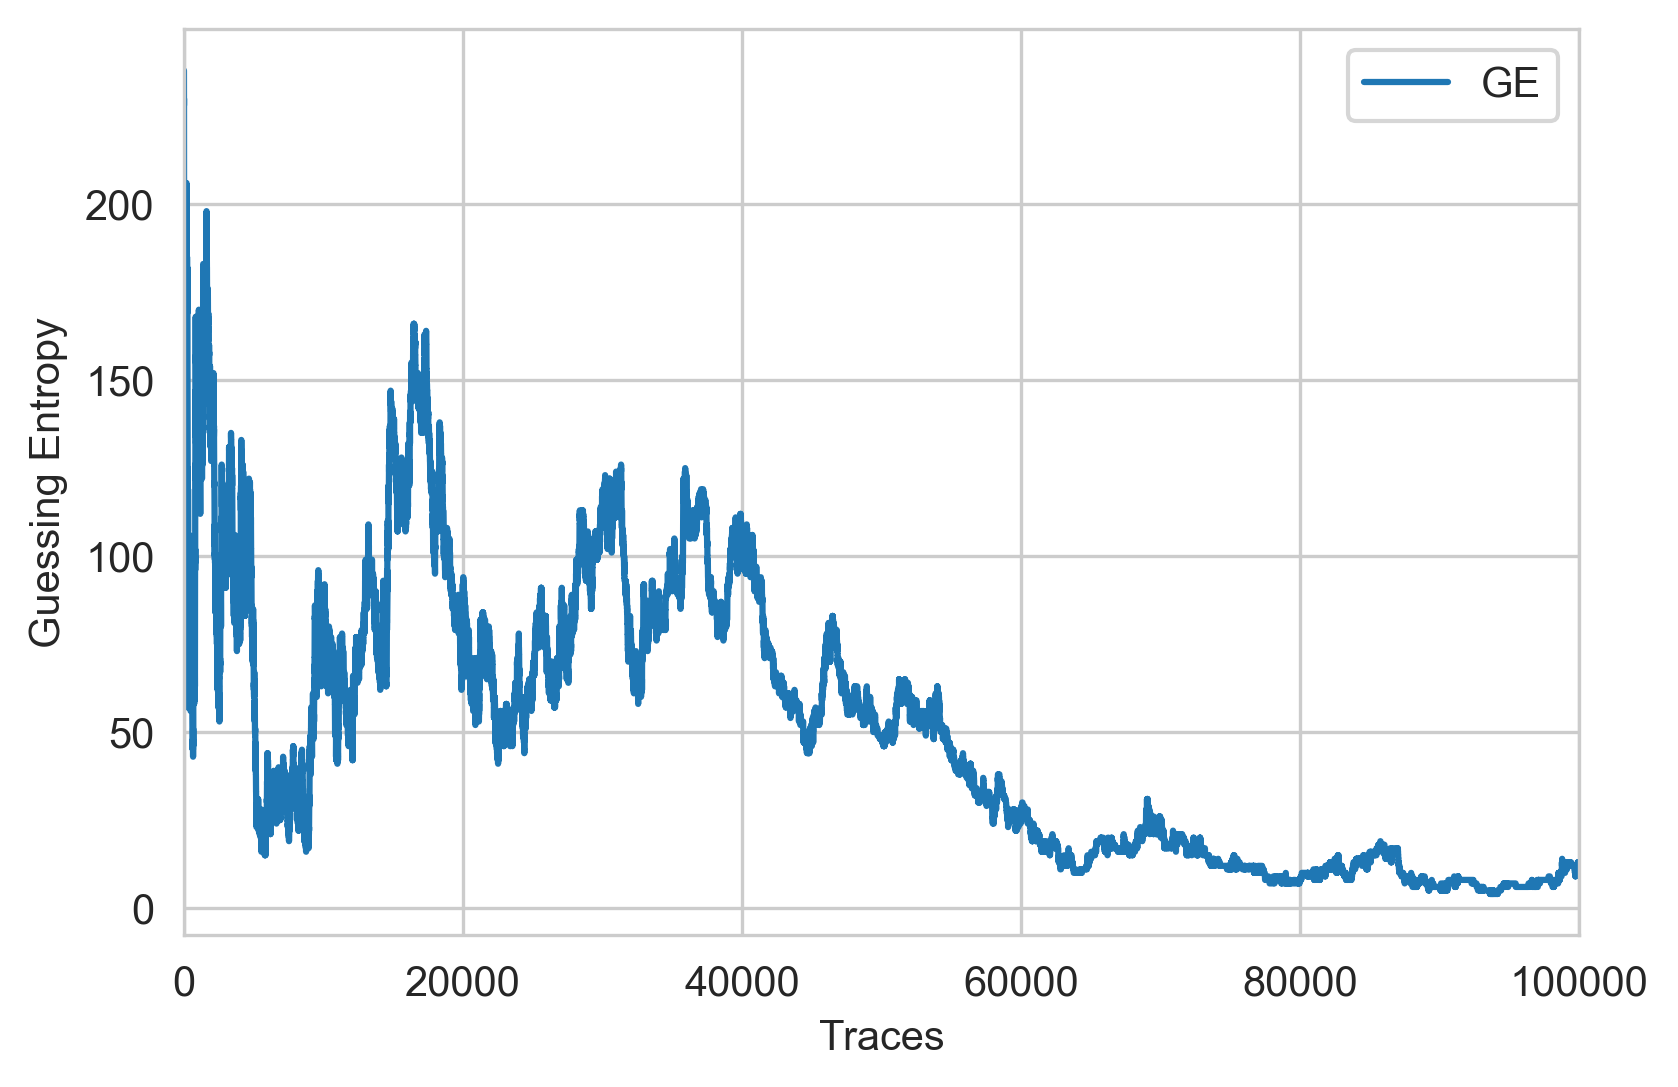

In [70]:
ge = compute_ge(key_rank_runs, model, key, correct_key, l_model, target_byte, X_attack, attack_data, key_rank_report_interval,
                key_rank_number_of_traces)

plt.plot(np.arange(1, key_rank_number_of_traces + 1), ge, label="GE")
plt.xlabel("Traces")
plt.ylabel("Guessing Entropy")
plt.xlim([0, key_rank_number_of_traces])
plt.legend()
plt.show()